# Simple Stock Price Prediction Model

Created by Marc Zeugin

### Import modules

In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from sklearn.svm import SVR
import yfinance as yf
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import math
import os

### Set tickers

In [2]:
#Add new tickers below:
add_to_tickers = ['TM']

mypath = 'F:/Marc/Github/Simple-Stock-Price-Prediction-Model/data'
tickers = [f.split('_')[0] for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]
for ticker in add_to_tickers:
    if ticker not in tickers:
        tickers.append(ticker)
        
print(tickers)

['AAL', 'AAPL', 'AAP', 'AMZN', 'FB', 'GOOG', 'MSFT', 'TM']


### Set options

In [3]:
period = '10y' #available options are 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max
training_data_split = 0.8 # as a decimal
shift = 2 # in days

### Load financial data from yahoo finance API or local folder if available

In [4]:
ticker_hist_list = []

for ticker in tickers:
    path = './data/' + ticker + '_data.json'
    if os.path.exists(path=path):
        with open(path) as f:
            temp_ticker_hist = pd.read_json(path)
        ticker_hist_list.append(temp_ticker_hist)
    else:
        temp_ticker = yf.Ticker(ticker=ticker)
        temp_ticker_hist = temp_ticker.history(period=period, start="2017-01-01", end="2021-12-29")
        ticker_hist_list.append(temp_ticker_hist)

### Save data to local folder

In [5]:
for i in range(len(ticker_hist_list)):
    ticker_hist_list[i].to_json('./data/' + tickers[i] + '_data.json')

### Display some data properties

In [6]:
for i in range(len(ticker_hist_list)):
    print(ticker_hist_list[i].info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1256 entries, 2017-01-03 to 2021-12-28
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1256 non-null   float64
 1   High          1256 non-null   float64
 2   Low           1256 non-null   float64
 3   Close         1256 non-null   float64
 4   Volume        1256 non-null   int64  
 5   Dividends     1256 non-null   float64
 6   Stock Splits  1256 non-null   int64  
dtypes: float64(5), int64(2)
memory usage: 110.8 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1256 entries, 2017-01-03 to 2021-12-28
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1256 non-null   float64
 1   High          1256 non-null   float64
 2   Low           1256 non-null   float64
 3   Close         1256 non-null   float64
 4   Volume        1256 non-null   int64  
 5   Di

### Display all stocks plots

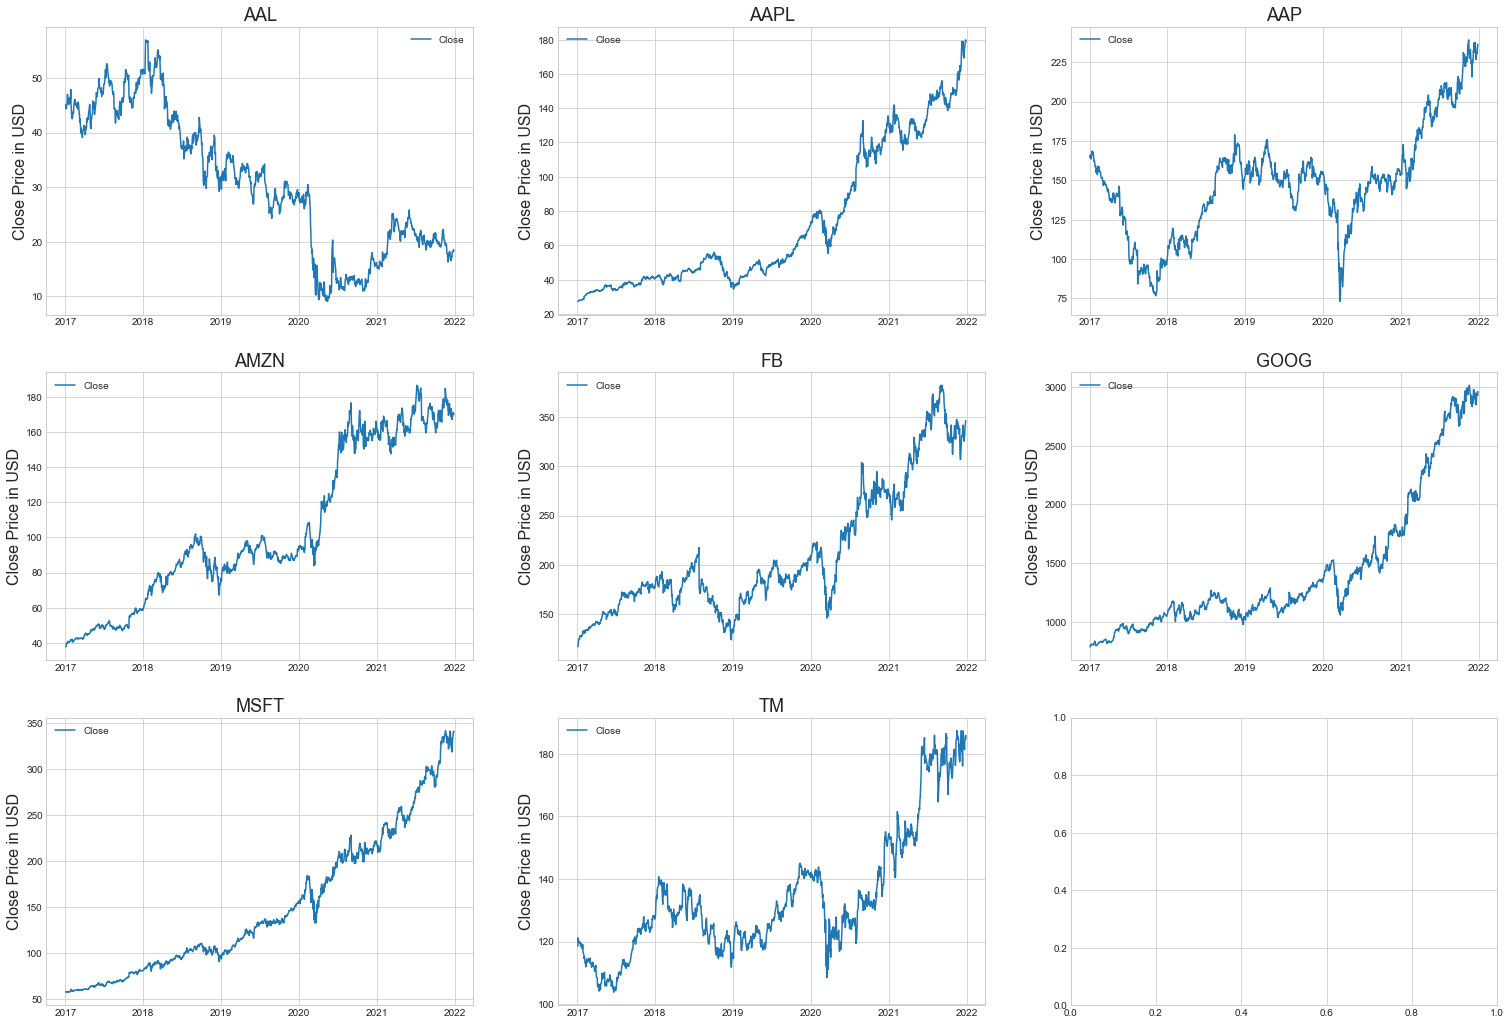

In [7]:
rows = int(math.ceil(len(tickers)/3))
cols = 3

fig, ax = plt.subplots(rows, cols, figsize=(26, 6*rows))

if rows == 1:
    for col in range(cols):
        ax[col].set_title(tickers[col], fontsize=18)
        ax[col].plot(ticker_hist_list[col]['Close'], label='Close')
        ax[col].legend(loc='best')
        ax[col].set_ylabel('Close Price in USD', fontsize=16)
else:
    for row in range(rows):
        for col in range(cols):
            if col + cols*row < len(tickers):
                ax[row, col].set_title(tickers[col + cols*row], fontsize=18)
                ax[row, col].plot(ticker_hist_list[col + cols*row]['Close'], label='Close')
                ax[row, col].legend(loc='best')
                ax[row, col].set_ylabel('Close Price in USD', fontsize=16)
plt.show()

### Create one dataset with all stock data

In [8]:
stock_data = pd.concat(ticker_hist_list, axis=1)
col_names = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']
stock_data.columns = [col_name + '.' + ticker for ticker in tickers for col_name in col_names]
stock_data.index.name = 'Date'
print(stock_data.shape)

(1256, 56)


In [9]:
print(stock_data.columns)

Index(['Open.AAL', 'High.AAL', 'Low.AAL', 'Close.AAL', 'Volume.AAL',
       'Dividends.AAL', 'Stock Splits.AAL', 'Open.AAPL', 'High.AAPL',
       'Low.AAPL', 'Close.AAPL', 'Volume.AAPL', 'Dividends.AAPL',
       'Stock Splits.AAPL', 'Open.AAP', 'High.AAP', 'Low.AAP', 'Close.AAP',
       'Volume.AAP', 'Dividends.AAP', 'Stock Splits.AAP', 'Open.AMZN',
       'High.AMZN', 'Low.AMZN', 'Close.AMZN', 'Volume.AMZN', 'Dividends.AMZN',
       'Stock Splits.AMZN', 'Open.FB', 'High.FB', 'Low.FB', 'Close.FB',
       'Volume.FB', 'Dividends.FB', 'Stock Splits.FB', 'Open.GOOG',
       'High.GOOG', 'Low.GOOG', 'Close.GOOG', 'Volume.GOOG', 'Dividends.GOOG',
       'Stock Splits.GOOG', 'Open.MSFT', 'High.MSFT', 'Low.MSFT', 'Close.MSFT',
       'Volume.MSFT', 'Dividends.MSFT', 'Stock Splits.MSFT', 'Open.TM',
       'High.TM', 'Low.TM', 'Close.TM', 'Volume.TM', 'Dividends.TM',
       'Stock Splits.TM'],
      dtype='object')


In [10]:
print(stock_data.head())

             Open.AAL   High.AAL    Low.AAL  Close.AAL  Volume.AAL  \
Date                                                                 
2017-01-03  45.688240  45.746221  44.586621  44.741234     6737800   
2017-01-04  45.060123  45.842850  44.789547  45.127766     5859600   
2017-01-05  44.953827  45.350023  44.074463  44.345036     6825300   
2017-01-06  44.306374  45.147087  43.939170  44.654255     7260200   
2017-01-09  44.460992  45.746217  44.238736  45.494972     4739100   

            Dividends.AAL  Stock Splits.AAL  Open.AAPL  High.AAPL   Low.AAPL  \
Date                                                                           
2017-01-03            0.0                 0  27.175512  27.299890  26.931449   
2017-01-04            0.0                 0  27.187240  27.342127  27.163773   
2017-01-05            0.0                 0  27.203670  27.424266  27.177855   
2017-01-06            0.0                 0  27.405486  27.729341  27.332737   
2017-01-09            0.0    

In [11]:
print(stock_data.describe())

          Open.AAL     High.AAL      Low.AAL    Close.AAL    Volume.AAL  \
count  1256.000000  1256.000000  1256.000000  1256.000000  1.256000e+03   
mean     30.886633    31.383096    30.349468    30.834485  2.531278e+07   
std      12.750909    12.820574    12.697936    12.764692  3.511586e+07   
min       8.770000     9.190000     8.250000     9.040000  1.352400e+06   
25%      19.970000    20.367501    19.530001    19.930000  5.465725e+06   
50%      30.608047    31.103882    30.120087    30.574699  8.588900e+06   
75%      42.492251    42.998496    41.923044    42.518808  3.555038e+07   
max      57.300620    57.583274    56.335700    56.988728  4.286171e+08   

       Dividends.AAL  Stock Splits.AAL    Open.AAPL    High.AAPL     Low.AAPL  \
count    1256.000000            1256.0  1256.000000  1256.000000  1256.000000   
mean        0.001035               0.0    73.032830    73.835990    72.272701   
std         0.010125               0.0    40.741940    41.241965    40.248610   


### Load macro dataset

In [12]:
macro_data = pd.read_excel("Macrodata.xlsx", index_col=0)
macro_data = macro_data.fillna(0)

In [13]:
print(macro_data)

            10y_Inflation  5y_Inflation  10y_Treasury  2y_Treasury  \
Date                                                                 
2004-01-02         0.0232        0.0208        0.0438       0.0194   
2004-01-05         0.0235        0.0209        0.0441       0.0195   
2004-01-06         0.0232        0.0205        0.0429       0.0184   
2004-01-07         0.0233        0.0205        0.0427       0.0184   
2004-01-08         0.0228        0.0199        0.0427       0.0185   
...                   ...           ...           ...          ...   
2021-12-23         0.0247        0.0272        0.0150       0.0071   
2021-12-27         0.0250        0.0275        0.0148       0.0076   
2021-12-28         0.0250        0.0278        0.0149       0.0074   
2021-12-29         0.0253        0.0283        0.0155       0.0075   
2021-12-30         0.0258        0.0286        0.0152       0.0073   

            5y_Treasury  TED_Spread  AAA_Bond_Yield  BAA_Bond_Yield  \
Date              

In [14]:
print(macro_data.shape)

(4531, 50)


### Adjust macrodata to stockdata size

In [15]:
macro_data = macro_data.drop(macro_data.index[:-stock_data.shape[0]-2])
macro_data = macro_data.drop(macro_data.index[-2:])
print(macro_data.shape)

(1256, 50)


In [16]:
#check if start and end date are the same
print(stock_data.head(2).index)
print(stock_data.tail(2).index)
print(macro_data.head(2).index)
print(macro_data.tail(2).index)

DatetimeIndex(['2017-01-03', '2017-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
DatetimeIndex(['2021-12-27', '2021-12-28'], dtype='datetime64[ns]', name='Date', freq=None)
DatetimeIndex(['2017-01-03', '2017-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
DatetimeIndex(['2021-12-27', '2021-12-28'], dtype='datetime64[ns]', name='Date', freq=None)


### Pull macroeconomic data

### Add macroeconomic data to dataset

In [17]:
all_data = pd.concat([stock_data, macro_data], axis=1)
print(all_data.shape)
print(all_data.columns)

(1256, 106)
Index(['Open.AAL', 'High.AAL', 'Low.AAL', 'Close.AAL', 'Volume.AAL',
       'Dividends.AAL', 'Stock Splits.AAL', 'Open.AAPL', 'High.AAPL',
       'Low.AAPL',
       ...
       'New_Cons_Durable_Goods', 'Industrial_Production_Total',
       'Nonfarm_Total', 'Debt_to_GDP', 'GDP', 'Gov_Expend_Total',
       'Income_per_Capita', 'GDP_Per_Capita', 'Median_House_Price',
       'Nonfarm_Payrolls_Total'],
      dtype='object', length=106)


### Add lagged features to the dataset

In [18]:
for col in all_data:
    for i in range(1, shift):
        all_data[col + str(-i)] = all_data[col].shift(i)

In [19]:
#remove first instance because of nan from shifting
for i in range(1, shift):
    all_data.drop(index=all_data.index[0], axis=0, inplace=True)

### Split into train and test

In [20]:
colum_name = f'Close.{"AAP"}'

X = all_data.copy()
X = X.drop(columns=[colum_name])
y = all_data[colum_name].copy()

print(f'X shape: {X.shape} & y shape: {y.shape}')

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=training_data_split, shuffle=False)

print(f'X_train shape: {X_train.shape} & X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape} & y_test shape: {y_test.shape}')

X shape: (1255, 211) & y shape: (1255,)
X_train shape: (1004, 211) & X_test shape: (251, 211)
y_train shape: (1004,) & y_test shape: (251,)


### Apply MinMaxScaler to dataset (include y?)

In [21]:
scaler_x = MinMaxScaler()
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.fit_transform(X_test)
print(f'X_train shape: {X_train.shape} & X_test shape: {X_test.shape}')
scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test = scaler_y.fit_transform(y_test.values.reshape(-1, 1))
print(f'X_train shape: {X_train.shape} & X_test shape: {X_test.shape}')

X_train shape: (1004, 211) & X_test shape: (251, 211)
X_train shape: (1004, 211) & X_test shape: (251, 211)


### Reshape input for LSTM model to match requirements

In [22]:
X_train_nn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_nn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print(f'X_train_nn shape: {X_train_nn.shape} & X_test_nn shape: {X_test_nn.shape}')
y_train_nn = y_train.copy()
y_test_nn = y_test.copy()
print(f'y_train_nn shape: {y_train.shape} & y_test_nn shape: {y_test.shape}')

X_train_nn shape: (1004, 211, 1) & X_test_nn shape: (251, 211, 1)
y_train_nn shape: (1004, 1) & y_test_nn shape: (251, 1)


### Setup the LSTM model

In [23]:
LSTM_Model = Sequential()
LSTM_Model.add(LSTM(50, return_sequences=True, input_shape=(X_train_nn.shape[1], 1)))
LSTM_Model.add(Dropout(0.2))
LSTM_Model.add(LSTM(50, return_sequences=True))
LSTM_Model.add(Dropout(0.2))
LSTM_Model.add(LSTM(50))
LSTM_Model.add(Dense(10))
LSTM_Model.add(Dense(1, activation='linear'))
LSTM_Model.compile(loss="mean_squared_error" , optimizer="adam")

In [24]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
LSTM_Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 211, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 211, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 211, 50)           20200     
                                                                 
 dropout_1 (Dropout)         (None, 211, 50)           0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 10)                510       
                                                                 
 dense_1 (Dense)             (None, 1)                 1

### Fit LSTM model

In [25]:
history = LSTM_Model.fit(X_train_nn, y_train_nn, validation_data=(X_test_nn, y_test_nn), epochs=100, batch_size=32, verbose=1)

Epoch 1/100
32/32 [==============================] - 10s 187ms/step - loss: 0.0980 - val_loss: 0.0713
Epoch 2/100
32/32 [==============================] - 5s 150ms/step - loss: 0.0535 - val_loss: 0.0697
Epoch 3/100
32/32 [==============================] - 5s 150ms/step - loss: 0.0537 - val_loss: 0.0722
Epoch 4/100
32/32 [==============================] - 5s 149ms/step - loss: 0.0531 - val_loss: 0.0685
Epoch 5/100
32/32 [==============================] - 5s 154ms/step - loss: 0.0542 - val_loss: 0.0695
Epoch 6/100
32/32 [==============================] - 5s 157ms/step - loss: 0.0527 - val_loss: 0.0689
Epoch 7/100
32/32 [==============================] - 5s 151ms/step - loss: 0.0548 - val_loss: 0.0670
Epoch 8/100
32/32 [==============================] - 5s 148ms/step - loss: 0.0524 - val_loss: 0.0714
Epoch 9/100
32/32 [==============================] - 5s 148ms/step - loss: 0.0527 - val_loss: 0.0667
Epoch 10/100
32/32 [==============================] - 5s 148ms/step - loss: 0.0527 - val_l

dict_keys(['loss', 'val_loss'])


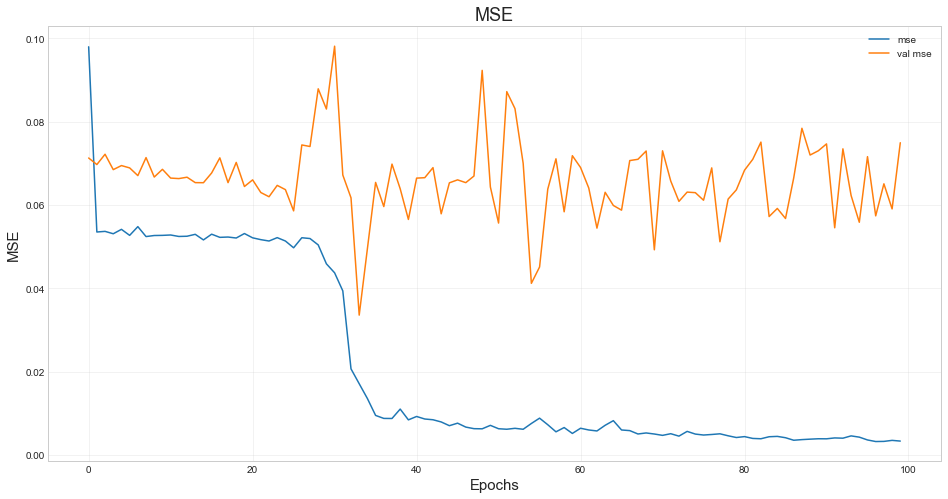

In [26]:
print(history.history.keys())
plt.figure(figsize=(16, 8))

# Accuracy
plt.plot(history.epoch, history.history['loss'], label = "mse")
plt.plot(history.epoch, history.history['val_loss'], label = "val mse")
plt.title("MSE", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("MSE", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

### Create predictions

In [27]:
test_predict = LSTM_Model.predict(X_test_nn)
y_test = scaler_y.inverse_transform(y_test)
test_predict = scaler_y.inverse_transform(test_predict)
print(test_predict.shape)

8/8 [==============================] - 1s 46ms/step
(251, 1)


### Calculate RMSE and MAE

In [28]:
print(f'RMSE: {math.sqrt(mean_squared_error(y_test, test_predict))}')
print(f'MSE: {mean_squared_error(y_test, test_predict)}')
print(f'MAE: {mean_absolute_error(y_test, test_predict)}')

RMSE: 25.885853437544466
MSE: 670.0774081900325
MAE: 21.583540167943422


### Plot prediction vs actual close price

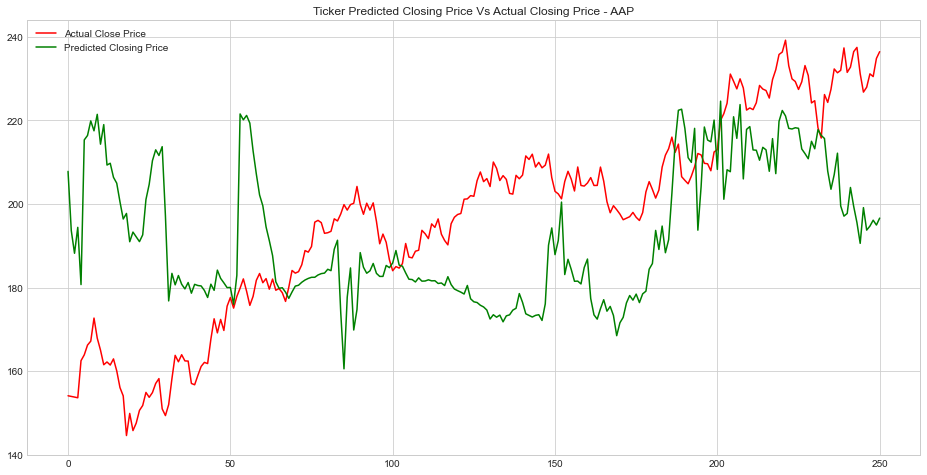

In [29]:
plt.figure(figsize=(16, 8))
plt.title(f'Ticker Predicted Closing Price Vs Actual Closing Price - {tickers[2]}')
plt.plot(y_test, color='red', label='Actual Close Price')
plt.plot(test_predict, color='green', label='Predicted Closing Price')
plt.legend(loc='best')
plt.show()

### Preparation for non-NN Models

In [30]:
X = stock_data.drop([f'Close.{"AAP"}'], axis=1)
y = stock_data[f'Close.{"AAP"}']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=training_data_split, shuffle=True)
X_train.sort_index(inplace=True)
X_test.sort_index(inplace=True)
y_train.sort_index(inplace=True)
y_test.sort_index(inplace=True)
print(f'Training sample size: {X_train.shape[0]} and testing sample size: {X_test.shape[0]}.')

Training sample size: 1004 and testing sample size: 252.


In [31]:
scaler_x2 = MinMaxScaler()
scaler_y2 = MinMaxScaler()
X_train = scaler_x2.fit_transform(X_train)
X_test = scaler_x2.fit_transform(X_test)
y_train = scaler_y2.fit_transform(y_train.values.reshape(-1, 1))
y_test = scaler_y2.fit_transform(y_test.values.reshape(-1, 1))

### Prediction with Logistic Regression

In [32]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

y_pred_lr = model_lr.predict(X_test)

pred_df_lr = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': y_pred_lr.tolist()})
print(pred_df_lr.head())
print(pred_df_lr.tail())

                  Actual              Predicted
0   [0.5425549953246084]   [0.5569586532576081]
1    [0.508754807926871]   [0.5166441441588804]
2   [0.5068060899435893]    [0.513807079287956]
3  [0.46606302286667667]  [0.47097971424676816]
4  [0.42635465540399353]  [0.43370103060428233]
                   Actual             Predicted
247  [0.9765992034747751]   [0.978181394991772]
248                 [1.0]  [1.0093942500958113]
249  [0.9666627932449104]  [0.9692314962297821]
250  [0.9462969422234707]   [0.952254872370672]
251  [0.9897230240218168]  [0.9882620550259409]


In [33]:
print(f'Accuracy score of the predictions: {r2_score(y_test, y_pred_lr)}')
print(f'RMSE score of the predictions: {math.sqrt(mean_squared_error(y_test, y_pred_lr))}')

Accuracy score of the predictions: 0.998736638833371
RMSE score of the predictions: 0.007797561413639572


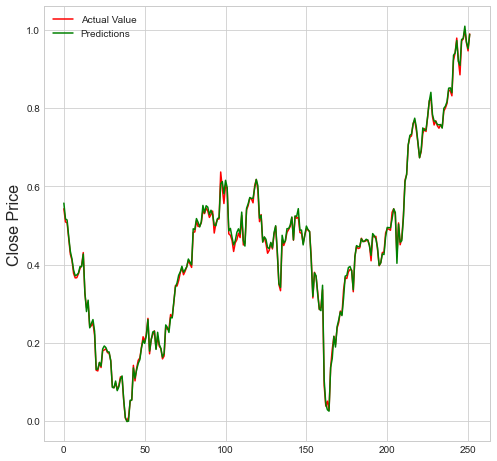

In [34]:
plt.figure(figsize=(8,8))
plt.plot(y_test, color='red')
plt.plot(y_pred_lr, color='green')
plt.ylabel('Close Price', fontsize=16)
plt.legend(['Actual Value', 'Predictions'], loc='best')
plt.show()

### Prediction with Random Forest

In [35]:
model_rf = RandomForestRegressor(n_estimators=100)
model_rf.fit(X_train, y_train)

y_pred_rf = model_rf.predict(X_test)
pred_df_rf = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': y_pred_rf.tolist()})
print(pred_df_rf.head())
print(pred_df_rf.tail())

                  Actual  Predicted
0   [0.5425549953246084]   0.550506
1    [0.508754807926871]   0.520097
2   [0.5068060899435893]   0.517957
3  [0.46606302286667667]   0.472645
4  [0.42635465540399353]   0.437584
                   Actual  Predicted
247  [0.9765992034747751]   0.980980
248                 [1.0]   0.985921
249  [0.9666627932449104]   0.985596
250  [0.9462969422234707]   0.952936
251  [0.9897230240218168]   0.984571


In [36]:
print(f'Accuracy score of the predictions: {r2_score(y_test, y_pred_rf)}')
print(f'RMSE score of the predictions: {math.sqrt(mean_squared_error(y_test, y_pred_rf))}')

Accuracy score of the predictions: 0.9969795804076528
RMSE score of the predictions: 0.012056706298591499


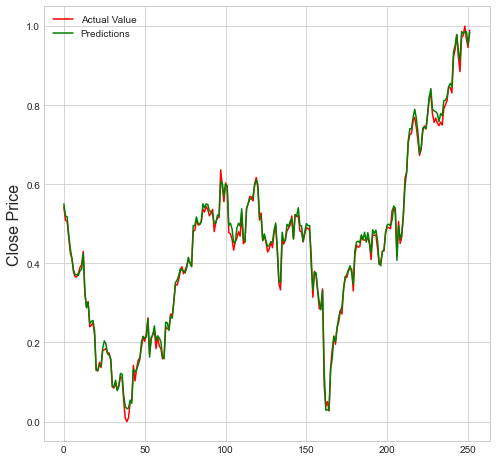

In [37]:
plt.figure(figsize=(8,8))
plt.plot(y_test, color='red')
plt.plot(y_pred_rf, color='green')
plt.ylabel('Close Price', fontsize=16)
plt.legend(['Actual Value', 'Predictions'], loc='best')
plt.show()

### Prediction with SVM

In [39]:
model_svm = SVR()
model_svm.fit(X_train, y_train)

y_pred_svm = model_svm.predict(X_test)
pred_df_svm = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': y_pred_svm.tolist()})
print(pred_df_svm.head())
print(pred_df_svm.tail())

                  Actual  Predicted
0   [0.5425549953246084]   0.461401
1    [0.508754807926871]   0.443080
2   [0.5068060899435893]   0.444623
3  [0.46606302286667667]   0.407163
4  [0.42635465540399353]   0.405065
                   Actual  Predicted
247  [0.9765992034747751]   0.881207
248                 [1.0]   0.885751
249  [0.9666627932449104]   0.858036
250  [0.9462969422234707]   0.883138
251  [0.9897230240218168]   0.892939


In [40]:
print(f'Accuracy score of the predictions: {r2_score(y_test, y_pred_svm)}')
print(f'RMSE score of the predictions: {math.sqrt(mean_squared_error(y_test, y_pred_svm))}')

Accuracy score of the predictions: 0.9261205563621094
RMSE score of the predictions: 0.059628907220836615


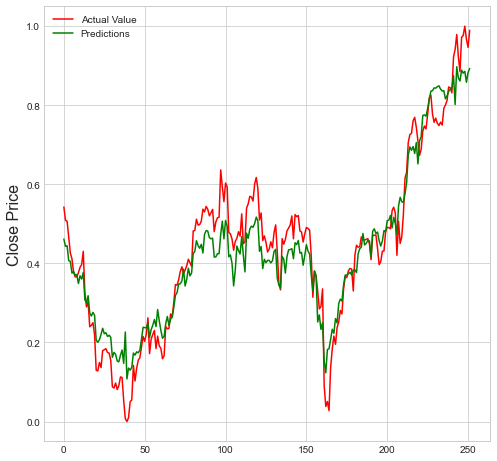

In [41]:
plt.figure(figsize=(8,8))
plt.plot(y_test, color='red')
plt.plot(y_pred_svm, color='green')
plt.ylabel('Close Price', fontsize=16)
plt.legend(['Actual Value', 'Predictions'], loc='best')
plt.show()

### Function to predict user selected stock performance

In [42]:
def predict_performance(symbol):
    print(f'PREDICTION FOR {symbol}')

### Allow user to input a stock ticker to predict

In [43]:
def user_input():
    stock_name = input("Please enter a Stock Ticker to predict: ").upper()
    
    if stock_name in tickers:
        path = './data/' + stock_name + '_data.json'
        with open(path) as f:
            temp_ticker_hist = pd.read_json(path)
        ticker_hist_list.append(temp_ticker_hist)
    else:
        try:
            temp_ticker = yf.Ticker(ticker=stock_name)
            temp_ticker_hist = temp_ticker.history(period=period)
            ticker_hist_list.append(temp_ticker_hist)
            tickers.append(stock_name)
                    
            ticker_hist_list[-1].to_json('./data/' + stock_name + '_data.json')
        except:
            print('Ticker not found!')
            user_input()
                
    predict_performance(stock_name)

# user_input()

# TODO

* Macrodata via API call
* Add more models
* Add actual forecast
* Add final dashboard output